In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm
from scipy.stats import norm

In [6]:
# Calculate annual Total Returns for the S&P500 (includes dividends)
stock_ret = pd.read_csv('data_csv.csv')

# I want annual data so I keep only January of each year
keep_list = [i for i, val in enumerate(stock_ret['Date']) if int(val.split('-')[1])==1]
ann_df = stock_ret.loc[keep_list].copy()
ann_df['year'] = [int(i.split('-')[0]) for i in ann_df['Date']]
ann_ret = ann_df['SP500']/ann_df['SP500'].shift(1) - 1
ann_df['ann_return'] = ann_ret + ann_df['Dividend']/ann_df['SP500']

# Focus on post World War II period
modern_df = ann_df.loc[948:].copy()

In [7]:
# Grab 1 year Treasury Bill Rate (sorry I named the variable fed_funds)
fed_funds = pd.read_csv('DGS1.csv')
fed_funds['year'] = [int(i.split('-')[0]) for i in fed_funds['DATE']]
fed_funds['month'] = [int(i.split('-')[1]) for i in fed_funds['DATE']]
yld = []
for i, val in enumerate(fed_funds['DGS1']):
    try:
        yld.append(float(val)/100)
    except:
        yld.append(0.0242)
fed_funds['yield'] = yld

# Keep just January of each year
keep_list = [i for i, val in enumerate(fed_funds['month']) if val==1]
fed_funds_df = fed_funds.loc[keep_list].copy()

fed_funds_df[0:5]

,DATE,DGS1,year,month,yield
0,1962-01-01,3.2795454545454545,1962,1,0.032795
12,1963-01-01,3.0386363636363636,1963,1,0.030386
24,1964-01-01,3.7922727272727273,1964,1,0.037923
36,1965-01-01,3.9420000000000000,1965,1,0.039420
48,1966-01-01,4.8766666666666667,1966,1,0.048767


In [8]:
# Add the T-Bill data to the dataframe with my stock return data
fed_funds_small = fed_funds_df[['year', 'yield']]
final_df = modern_df.merge(fed_funds_small, how='left', on='year')
final_df.dropna(inplace=True)
final_df.reset_index(inplace=True, drop=True)
final_df['excess_return'] = final_df['ann_return'] - final_df['yield']

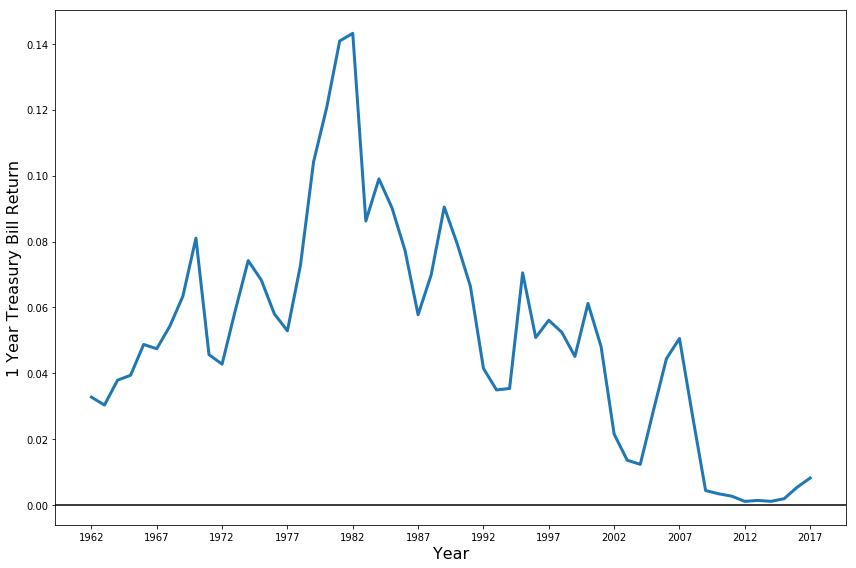

In [9]:
# Plot T-Bill Rate

fig, ax = plt.subplots(figsize=(12,8))
ax  = sns.lineplot(x=final_df['year'], y='yield', data=final_df, linewidth=3, ci=None)
# ax2 = sns.lineplot(x=final_df['year'], y='ann_return', data=final_df, linewidth=3)
ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("1 Year Treasury Bill Return",fontsize=16)
plt.xticks(range(min(final_df['year']), max(final_df['year'])+1, 5))
plt.axhline(y=0, color='black')
plt.tight_layout()

plt.savefig(fname='cash_rate', dpi=150)
plt.show()

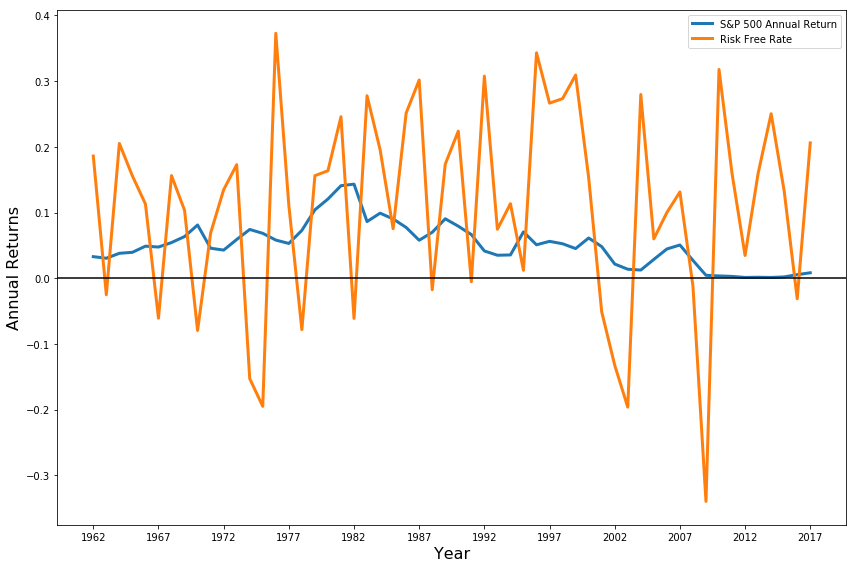

In [10]:
# Plot T-Bill rate and S&P 500 returns

fig, ax = plt.subplots(figsize=(12,8))
ax  = sns.lineplot(x=final_df['year'], y='yield', data=final_df, linewidth=3, ci=None, label='S&P 500 Annual Return')
ax2 = sns.lineplot(x=final_df['year'], y='ann_return', data=final_df, linewidth=3, label='Risk Free Rate')
ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("Annual Returns",fontsize=16)
plt.xticks(range(min(final_df['year']), max(final_df['year'])+1, 5))
plt.axhline(y=0, color='black')
plt.legend()
plt.tight_layout()

plt.savefig(fname='stock_cash_rate', dpi=150)
plt.show()

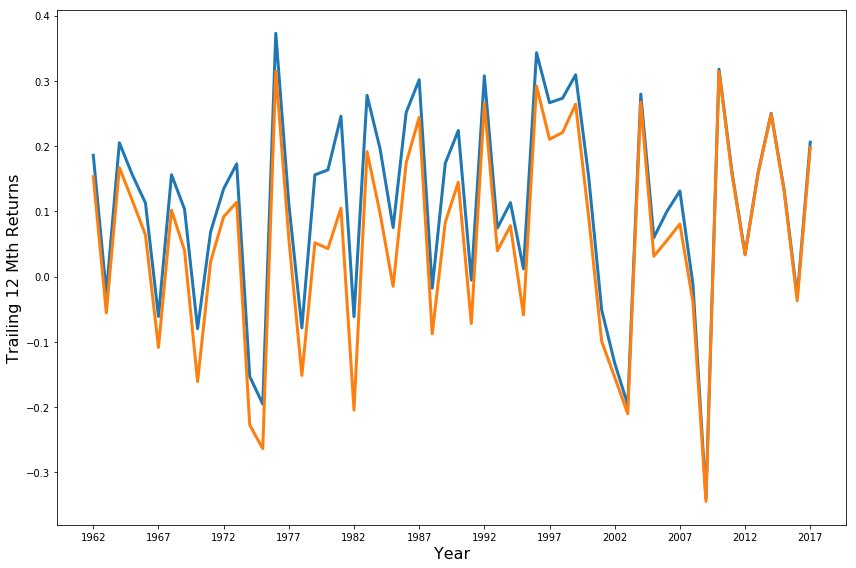

In [11]:
# Plot S&P 500 excess return over cash and compare with S&P 500 total return

fig, ax = plt.subplots(figsize=(12,8))
ax  = sns.lineplot(x=final_df['year'], y='ann_return', data=final_df, linewidth=3, ci=None)
ax2 = sns.lineplot(x=final_df['year'], y='excess_return', data=final_df, linewidth=3, ci=None)
ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("Trailing 12 Mth Returns",fontsize=16)
plt.xticks(range(min(final_df['year']), max(final_df['year'])+1, 5))
plt.tight_layout()

plt.savefig(fname='port_hist', dpi=150)
plt.show()

In [12]:
# Calculate mean return and standard deviation over sample
mean_ret = np.mean(final_df['ann_return'])
mean_vol = np.var(final_df['ann_return'])**0.5
cash_ret = np.mean(final_df['yield'])
cash_vol = np.var(final_df['yield'])**0.5

print('Stock Return: %.2f' % (mean_ret*100) + '%', 'Stock Vol: %.2f' % (mean_vol*100) + '%')
print('Cash Return: %.2f' % (cash_ret*100) + '%', 'Cash Vol: %.2f' % (cash_vol*100) + '%')

Stock Return: 10.88% Stock Vol: 15.22%
Cash Return: 5.11% Cash Vol: 3.36%


In [13]:
# Calculate standard error
stock_SE = mean_vol/(final_df.shape[0]**0.5)
cash_SE = cash_vol/(final_df.shape[0]**0.5)

print(final_df.shape[0])
print('Stock SE: %.2f' % (stock_SE*100) + '%')
print('Cash SE: %.2f' % (cash_SE*100) + '%')

56
Stock SE: 2.03%
Cash SE: 0.45%


In [14]:
# Run Monte Carlo Simulations

experiments = 5000     # Experiments is number of simulations to run
# experiments = 10000
Ns = range(1, 31)      # Number of years to simulate over
Ns = range(1, 31)

stocks_win_list = []

for N in Ns:
    
    avg_stocks = []
    avg_cash = []
    beat_ratios = []
    new_mean_stocks = []
    new_mean_cash = []
    geo_mean_stocks = []
    geo_mean_cash = []
    all_stocks = []
    all_cash = []
    
    for experiment in range(experiments):
        
        # Model stock returns as a random normal variable
        # The expected reuturn for stocks is itself a random variable with a Student's t distribution
        stock_t_variable = np.random.standard_t(final_df.shape[0], size=1)*stock_SE + (mean_ret - 0.00)
        stock_random = np.random.normal(stock_t_variable, mean_vol, (N, 1))
        
        # Model cash as a random normal variable
        cash_t_variable = np.random.standard_t(final_df.shape[0], size=1)*cash_SE + cash_ret
        cash_random = np.array([max(i[0],0) for i in np.random.normal(cash_t_variable, cash_vol, (N, 1))]).reshape((1,-1)).T
        
        # Calculate the number of times that stock beats cash
        beat_ratio = len(list(stock_random[stock_random>cash_random]))/stock_random.shape[0]*100
        beat_ratios.append(beat_ratio)
    
        new_mean_stocks.append(np.mean(stock_random))
        new_mean_cash.append(np.mean(cash_random))
        
        # Store the compounded total return of stocks and cash for compariing end of period wealth
        geo_mean_stocks.append(np.cumprod(stock_random + 1)[N-1])
        geo_mean_cash.append(np.cumprod(cash_random + 1)[N-1])
    
        [all_stocks.append(i) for i in stock_random]
        [all_cash.append(i) for i in cash_random]

    # print('Cash wins %.2f' % (100 - np.mean(beat_ratios)) + '% of the time')

    stocks_win_percent = sum([1 for i in (np.array(geo_mean_stocks) > np.array(geo_mean_cash)) if i==True])/experiments
    print('Years held: ' + str(N) + '     Cash wins %.2f' % (100 - stocks_win_percent*100) + '% of the time')
    stocks_win_list.append(stocks_win_percent)

# Histogram that shows the distribution of the Monte Carlo Results for S&P 500 and cash returns for N scenarios
# fig, ax = plt.subplots(figsize=(12,8))
# sns.distplot(stock_random, kde=False, bins=100, label='S&P 500 Annual Return')
# sns.distplot(cash_random, kde=False, bins=100, label='Cash Annual Return', color='orange')
# # plt.axvline(x=0, color='red')

# ax.set_xlabel("Annual Return (Not Inflation Adjusted)",fontsize=16)
# ax.set_ylabel("Frequency",fontsize=16)
# plt.xlim(-0.6, 0.8)
# #plt.ylim(0, 200)
# plt.legend()
# plt.tight_layout()

# # plt.savefig(fname='port_hist_1', dpi=150)
# plt.show()

Years held: 1     Cash wins 37.36% of the time
Years held: 2     Cash wins 32.14% of the time
Years held: 3     Cash wins 28.96% of the time
Years held: 4     Cash wins 28.02% of the time
Years held: 5     Cash wins 24.46% of the time
Years held: 6     Cash wins 23.18% of the time
Years held: 7     Cash wins 21.80% of the time
Years held: 8     Cash wins 21.48% of the time
Years held: 9     Cash wins 19.32% of the time
Years held: 10     Cash wins 20.14% of the time
Years held: 11     Cash wins 18.20% of the time
Years held: 12     Cash wins 16.64% of the time
Years held: 13     Cash wins 16.24% of the time
Years held: 14     Cash wins 16.20% of the time
Years held: 15     Cash wins 16.20% of the time
Years held: 16     Cash wins 13.96% of the time
Years held: 17     Cash wins 14.14% of the time
Years held: 18     Cash wins 13.22% of the time
Years held: 19     Cash wins 13.34% of the time
Years held: 20     Cash wins 12.58% of the time
Years held: 21     Cash wins 11.98% of the time
Y

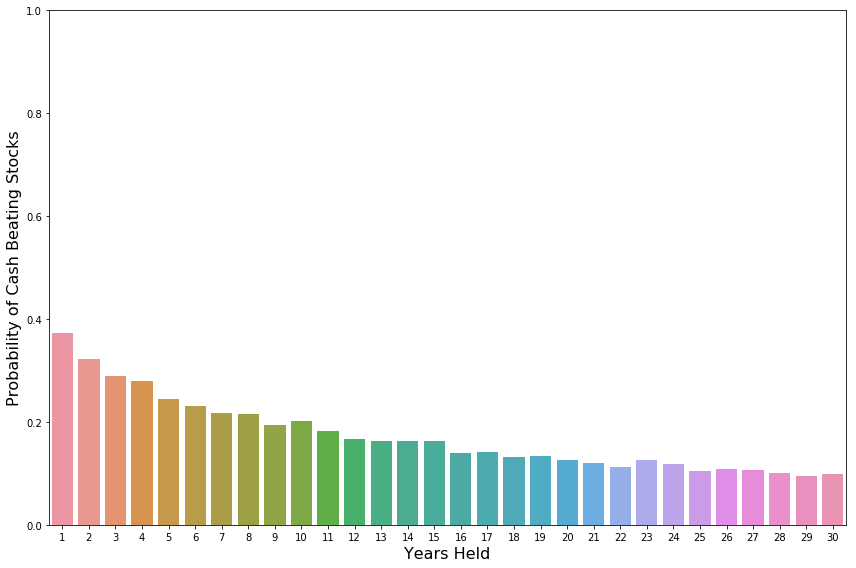

In [15]:
# Bar plot of cash win percentage vs. holding period

stocks_win_df = pd.DataFrame()

stocks_win_df['years_held'] = Ns
stocks_win_df['stocks_win'] = [(1-i) for i in stocks_win_list]

fig, ax = plt.subplots(figsize=(12,8))
ax  = sns.barplot(x='years_held', y='stocks_win', data=stocks_win_df, linewidth=3, ci=None)
ax.set_xlabel("Years Held",fontsize=16)
ax.set_ylabel("Probability of Cash Beating Stocks",fontsize=16)
plt.ylim(0.0, 1.0)
plt.tight_layout()

plt.savefig(fname='cash_wins_rate', dpi=150)
plt.show()

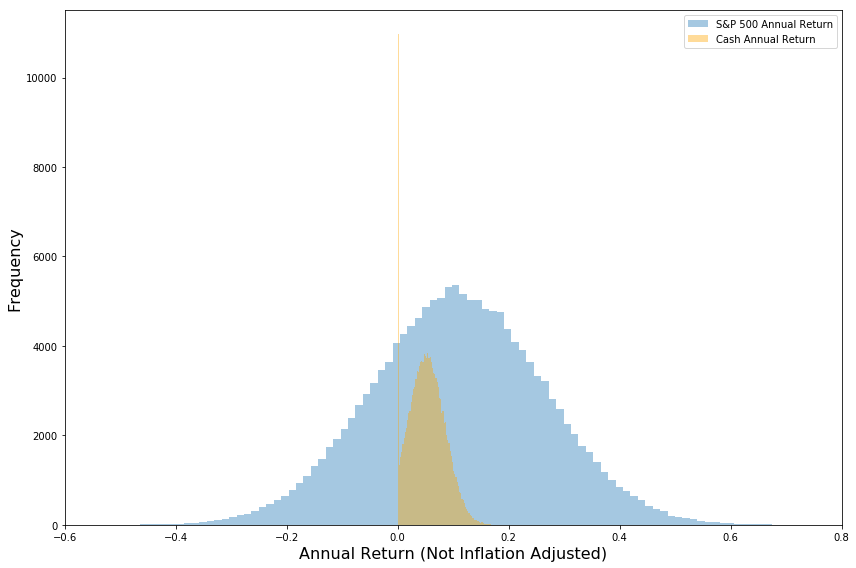

In [16]:
# Histogram that shows the distribution of the Monte Carlo Results for S&P 500 and cash returns for N scenarios
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(all_stocks, kde=False, bins=100, label='S&P 500 Annual Return')
sns.distplot(all_cash, kde=False, bins=100, label='Cash Annual Return', color='orange')

ax.set_xlabel("Annual Return (Not Inflation Adjusted)",fontsize=16)
ax.set_ylabel("Frequency",fontsize=16)
plt.xlim(-0.6, 0.8)
plt.legend()
plt.tight_layout()

plt.savefig(fname='port_hist_3', dpi=150)
plt.show()

In [17]:
# Check stats across ALL experiments
print('Stock Return: %.2f' % (np.mean(all_stocks)*100) + '%')
print('Cash Return: %.2f' % (np.mean(all_cash)*100) + '%')
print('Cash Beats: %.2f' % (100 - np.mean(beat_ratios)) + '% of the time')

Stock Return: 10.87%
Cash Return: 5.21%
Cash Beats: 35.86% of the time


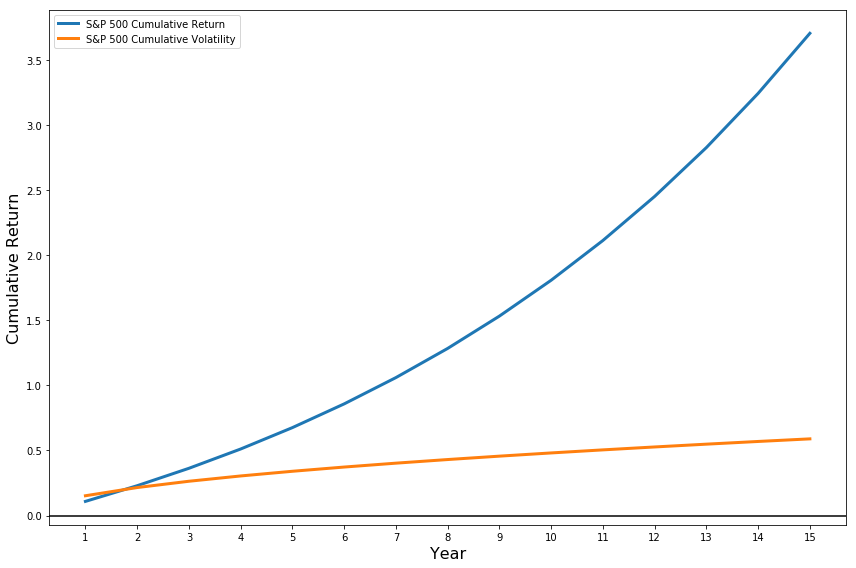

In [18]:
# Compare how expected return and volatility increase with time

hors = range(1,16)
hor_ret = []
hor_vol = []

for h in hors:
    hor_ret.append((1 + mean_ret)**h - 1)  # Store compounded returns in a list
    hor_vol.append(mean_vol*(h**0.5))      # Store cumulative volatility in a list

# Store results for cumulative return and volatility in dataframe for plotting
hor_df = pd.DataFrame()
hor_df['year'] = [i for i in hors]
hor_df['cum_return'] = hor_ret
hor_df['cum_vol'] = hor_vol
    
fig, ax = plt.subplots(figsize=(12,8))
ax  = sns.lineplot(x='year', y='cum_return', data=hor_df, linewidth=3, ci=None, label='S&P 500 Cumulative Return')
ax2 = sns.lineplot(x='year', y='cum_vol', data=hor_df, linewidth=3, label='S&P 500 Cumulative Volatility')
ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("Cumulative Return",fontsize=16)
plt.xticks(range(min(hor_df['year']), max(hor_df['year'])+1, 1))
plt.axhline(y=0, color='black')
plt.legend()
plt.tight_layout()

plt.savefig(fname='return_risk_cumul', dpi=150)
plt.show()    